In [1]:
import time
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt
import h5py

from datetime import datetime
import yfinance as yf

In [2]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2022-07-01'
)
data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2010-01-04,6.478998,23.474916,26.893303,136.536911,67.992645,42.974461,40.160053,18.498020,6.695000,29.669847,37.090000,23.853483,27.843176,18.196341
2010-01-05,6.490200,23.482506,27.921583,138.950912,68.344704,42.476147,40.173203,18.274250,6.734500,30.244549,37.700001,23.782896,27.773720,18.091408
2010-01-06,6.386965,23.338392,28.791655,137.467789,67.992645,42.821636,39.982655,18.267763,6.612500,30.410730,37.619999,23.748514,27.626122,17.958483
2010-01-07,6.375158,23.095684,28.870739,140.157867,71.513306,42.516010,39.765816,18.222359,6.500000,31.013130,36.889999,23.593327,27.634809,18.014450
2010-01-08,6.417541,23.254963,28.396168,137.507248,73.053574,42.662189,39.713234,17.885096,6.676000,30.936972,36.689999,23.601694,27.678219,18.427210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,140.444214,264.041046,44.782070,289.352966,52.030647,174.613449,138.010956,60.242386,116.459999,111.237907,387.720001,326.949341,97.462357,149.027634
2022-06-27,140.444214,261.269470,44.754002,287.470154,51.805439,174.450607,136.959244,60.118153,113.220001,110.346634,381.070007,325.297302,96.296165,148.712265
2022-06-28,136.260422,252.974426,44.173870,286.237244,51.160877,169.488739,134.731583,59.516102,107.400002,109.815674,365.630005,314.870514,95.608398,147.317078


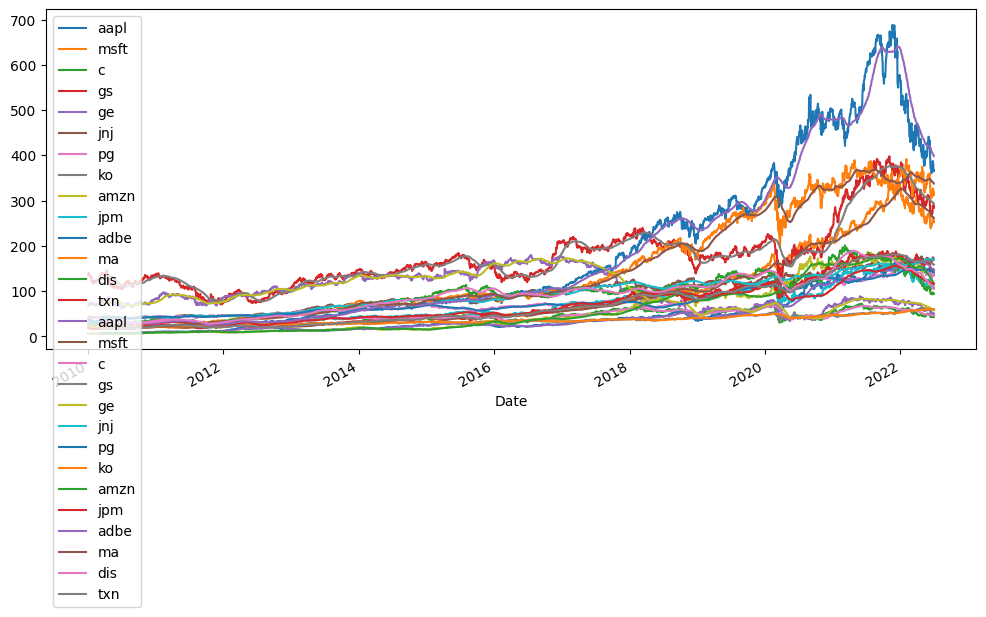

In [3]:
sma = data.rolling(50).mean()

plot = bt.merge(data, sma).plot(figsize=(12, 5))

In [4]:
st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 
bt_runtime_seconds = et-st
res.display()

Run time: 1.46 seconds
Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2022-06-30
Risk-free rate       0.00%

Total Return         262.07%
Daily Sharpe         0.70
Daily Sortino        1.06
CAGR                 10.85%
Max Drawdown         -31.75%
Calmar Ratio         0.34

MTD                  -13.76%
3m                   -24.47%
6m                   -26.27%
YTD                  -26.12%
1Y                   -29.33%
3Y (ann.)            2.06%
5Y (ann.)            4.92%
10Y (ann.)           12.00%
Since Incep. (ann.)  10.85%

Daily Sharpe         0.70
Daily Sortino        1.06
Daily Mean (ann.)    11.73%
Daily Vol (ann.)     16.78%
Daily Skew           -0.71
Daily Kurt           5.40
Best Day             5.27%
Worst Day            -8.03%

Monthly Sharpe       0.69
Monthly Sortino      1.09
Monthly Mean (ann.)  11.91%
Monthly Vol (ann.)   17.16%
Monthly Skew         -0.89
Monthly Kurt         1.75
Best Month          

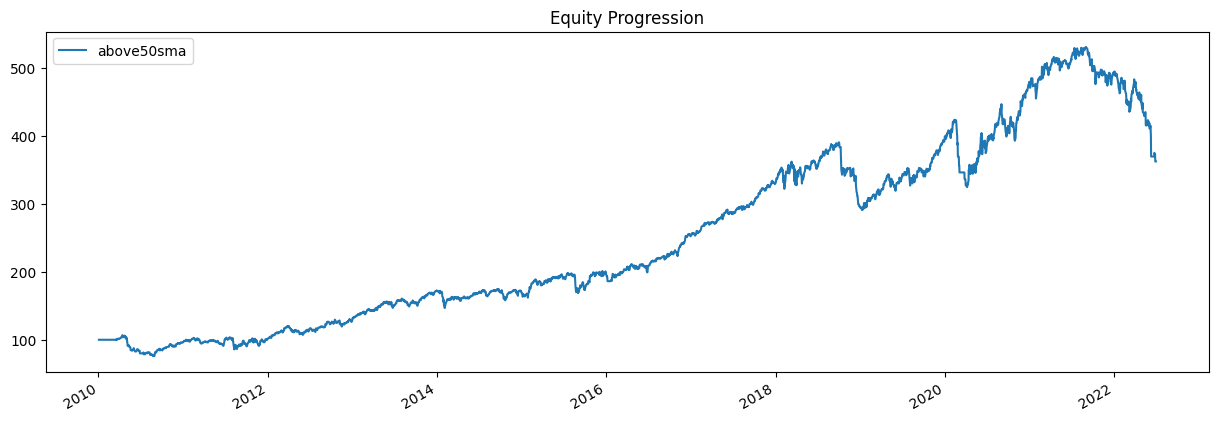

In [5]:
# what does the equity curve look like?
res.plot();

In [6]:
atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)

from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy import TracerType
from AtlasPy.ast import AssetReadNode, AssetDifferenceNode, \
      ExchangeViewNode, AllocationNode, StrategyNode, AssetOpNodeVariant, ExchangeViewFilterType

In [7]:
exchange_id = "test"
portfolio_id = "test_p"
strategy_id = "test_s"
exchange_path_fast = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/test/data_sp500.h5"
initial_cash = 100.0
hydra = Hydra()

In [8]:
exchange = hydra.addExchange(exchange_id, exchange_path_fast)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [9]:
read_close = AssetReadNode.make("close", 0, exchange)
read_50_ma = AssetReadNode.make("50_ma", 0, exchange)
spread = AssetDifferenceNode(read_close, read_50_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
exchange_view.setFilter(ExchangeViewFilterType.GREATER_THAN, 0.0)
allocation = AllocationNode(exchange_view)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))

In [10]:
strategy.enableTracerHistory(TracerType.NLV)

In [18]:
time_sum = 0
n = 100
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 2.6207}")

Time elapsed Avg: 395.220 us
Total return: 262.109%
Epsilon: 0.0003877146672262022


In [19]:
bt_runtime_micros = bt_runtime_seconds * 1000000
speedup = bt_runtime_micros / avg_time_micros
print(f"Speedup: {speedup:.3f}x")

Speedup: 3689.142x


C:\Users\natha\AppData\Local\Temp\ipykernel_6956\2118328846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Atlas"] = strategy.getHistory(TracerType.NLV)


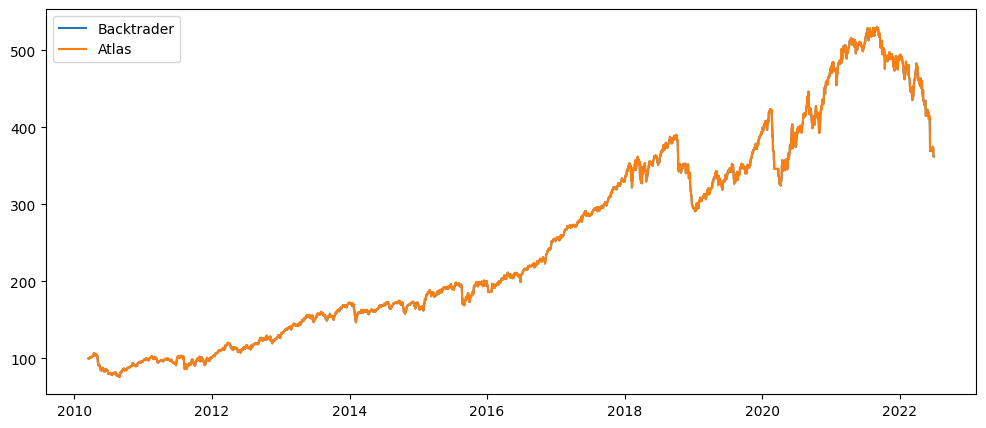

In [34]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

df_res = res.prices.iloc[50:]
df_res["Atlas"] = strategy.getHistory(TracerType.NLV)

ax.plot(df_res["above50sma"], label='Backtrader')
ax.plot(df_res["Atlas"], label='Atlas')

ax.legend()